In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.stats import gaussian_kde
from itertools import chain
from scipy.interpolate import interp1d
import numpy_financial as npf

# IMPORTING DATA

In [2]:

# Initialize the lists
EE_load = []
ET_load = []
WS_10m = []
WS_power_curves = []
P_curve_Ene = []
P_curve_Gam = []
P_curve_Nor = []
P_curve_Rep = []
P_curve_Ves = []
P_curve_Gam2 = []

# File paths
filename1 = "EE_load.csv"
filename2 = "ET_load.csv"
filename3 = "Wind speed 10m.csv"
filename4 = "Power curve wind speed.csv"
filename5 = "Power curves.csv"


# EE_LOAD DATA IMPORT
with open(filename1, "r") as file:
    csv_reader = csv.reader(file)
    
    # Read all rows and append them as sublists to EE_load
    for row in csv_reader:
        EE_load.append([float(value) for value in row])

# Flatten EE_load into a single list
EE_load = list(chain.from_iterable(EE_load))

# ET_LOAD DATA IMPORT
with open(filename2, "r") as file:
    csv_reader = csv.reader(file)
    
    # Read all rows and append them as sublists to ET_load
    for row in csv_reader:
        ET_load.append([float(value) for value in row])

# Flatten ET_load into a single list
ET_load = list(chain.from_iterable(ET_load))

# WIND SPEED DATA IMPORT
with open(filename3, "r") as file:
    csv_reader = csv.reader(file)
    
    # Read all rows and append them as sublists to WS_10m
    for row in csv_reader:
        WS_10m.append([float(value) for value in row])

# Flatten WS_10m into a single list
WS_10m = list(chain.from_iterable(WS_10m))

# POWER CURVE WIND SPEED DATA IMPORT
with open(filename4,"r") as file:
    csv_reader = csv.reader(file)
    
    # Read all rows and append them
    for row in csv_reader:
        WS_power_curves.append([float(value) for value in row])

# Flatteninto a single list
WS_power_curves = list(chain.from_iterable(WS_power_curves))

# POWER CURVE DATA IMPORT
with open(filename5, "r") as file:
    csv_reader = csv.reader(file, delimiter=';')  # Use semicolon as the delimiter
    
    
    # Read each row and append the values to the respective lists
    for row in csv_reader:
        P_curve_Ene.append(float(row[0]))
        P_curve_Gam.append(float(row[1]))
        P_curve_Nor.append(float(row[2]))
        P_curve_Rep.append(float(row[3]))
        P_curve_Ves.append(float(row[4]))
        P_curve_Gam2.append(float(row[5]))

# Print the data
#print("EE_load:", EE_load)
#print("ET_load:", ET_load)
#print("Wind speed at 10m:", WS_10m)
#print("Power curve wind speed:", WS_power_curves)
#print("P_curve_Enercon:", P_curve_Ene)
#print("P_curve_Gamesa:", P_curve_Gam)
#print("P_curve_Nordex:", P_curve_Nor)
#print("P_curve_Repower:", P_curve_Rep)
#print("P_curve_Vestas:", P_curve_Ves)

# TURBINE ELECTRICITY PRODUCTION ANALYSIS

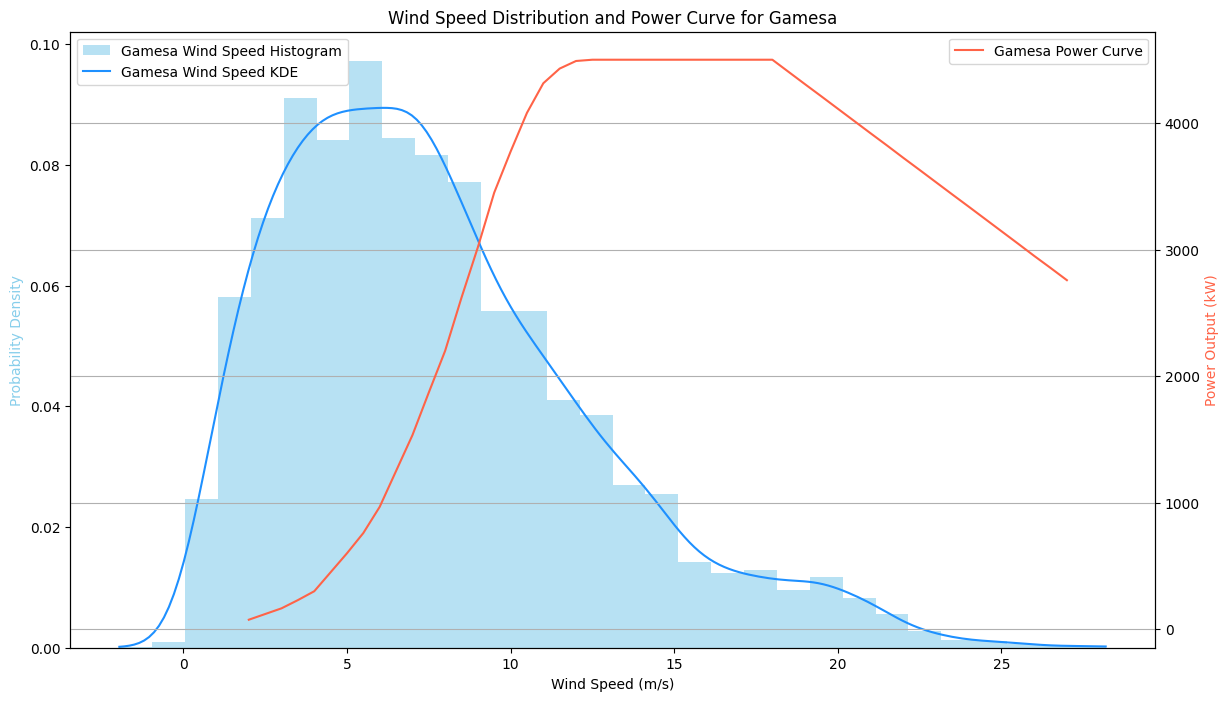

Energy produced by Gamesa: 17.48 GWh
Equivalent time for Gamesa: 3884 hours
**Total Electric Energy Demand**
- Demand: 21.05 GWh


**Total Useful Electric Energy Produced by the Turbine**
- Energy used by our system: 9.27 GWh
- Percentage of all energy generated: 53.02%
- Percentage of all electricity demand: 44.02%


**Total Electric Energy Surplus**
- Surplus energy to be sold: 8.21 GWh
- Percentage of all energy generated: 46.98%


**Total Electric Energy Deficit**
- Deficit to be covered: 11.79 GWh
- Percentage of all demand: 55.98%


In [3]:
def wind_turbine_analysis(turbine_name, z_2, P_curve, max_power, EE_load):
    # Parameters
    alpha = 0.27
    z_1 = 10  # m

    # Calculate hub wind speeds
    WS_hub = np.array([i * ((z_2 / z_1) ** alpha) for i in WS_10m])

    # Function to calculate power with linear interpolation
    def calculate_power(w_s_z2, w_s_ref, p_o_ref):
        p_o_z2 = np.array([])
        for i in range(0, len(w_s_z2)):
            for j in range(0, len(w_s_ref)):
                if w_s_ref[j] > w_s_z2[i]:
                    k = (p_o_ref[j] - p_o_ref[j-1]) / (w_s_ref[j] - w_s_ref[j-1])
                    n = p_o_ref[j] - k * w_s_ref[j]
                    p_o_z2 = np.append(p_o_z2, k * w_s_z2[i] + n)
                    break
        return p_o_z2

    # Calculate power
    P_o = calculate_power(WS_hub, WS_power_curves, P_curve)
    
    # Function to plot PDF using histogram and line graph of power curve
    def plot_combined(wind_speed_data, power_curve_speed, power_curve_output, wind_label, power_curve_label, bins=30, alpha=0.6):
        density = gaussian_kde(wind_speed_data)
        xs = np.linspace(min(wind_speed_data), max(wind_speed_data), 200)
        
        # Create the plot
        fig, ax1 = plt.subplots(figsize=(14, 8))
        
        # Plot histogram and KDE of wind speed on the primary y-axis
        color = '#87CEEB'  # SkyBlue
        ax1.hist(wind_speed_data, bins=bins, density=True, alpha=alpha, label=wind_label + ' Histogram', color=color)
        ax1.plot(xs, density(xs), label=wind_label + ' KDE', color='#1E90FF')  # DodgerBlue
        
        # Create a secondary y-axis for the power curve
        ax2 = ax1.twinx()
        
        # Filter out zero values from the power curve data
        filtered_power_curve_output = [p for p in power_curve_output if p > 0]
        filtered_power_curve_speed = [s for s, p in zip(power_curve_speed, power_curve_output) if p > 0]
        
        # Plot the power curve as a line graph
        ax2.plot(filtered_power_curve_speed, filtered_power_curve_output, label=power_curve_label, color='#FF6347')  # Tomato

        # Add labels and title
        ax1.set_xlabel('Wind Speed (m/s)')
        ax1.set_ylabel('Probability Density', color=color)
        ax2.set_ylabel('Power Output (kW)', color='#FF6347')
        plt.title(f'Wind Speed Distribution and Power Curve for {turbine_name}')
        
        # Combine legends from both axes
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        
        # Show the plot
        plt.grid(True)
        plt.show()
    
    # Plot PDF and power curve
    plot_combined(WS_hub, WS_power_curves, P_curve, f'{turbine_name} Wind Speed', f'{turbine_name} Power Curve')

    # Function to calculate energy produced
    def calculate_energy(power_output):
        energy = np.sum(power_output)  # Energy in kWh
        return energy

    # Calculate energy produced
    energy = calculate_energy(P_o)
    print(f"Energy produced by {turbine_name}: {energy / 1_000_000:.2f} GWh")

    # Calculate equivalent time H_eq (in hours)
    H_eq = energy / max_power
    print(f"Equivalent time for {turbine_name}: {H_eq:.0f} hours")

    # Calculate the energy deficits and surpluses
    EE_deficit = []
    EE_surplus = []

    # Calculate the difference between the generated energy and the load
    EE_delta = P_o - EE_load

    for delta in EE_delta:
        if delta <= 0:  # If the load is bigger
            EE_deficit.append(abs(delta))
            EE_surplus.append(0)
        else:
            EE_deficit.append(0)
            EE_surplus.append(delta)

    # Sum the total deficits and surpluses
    total_deficit = sum(EE_deficit)
    total_surplus = sum(EE_surplus)
    total_energy_demand = sum(EE_load)
    total_energy_produced = sum(P_o)

    
    # Print the results
    print(f"**Total Electric Energy Demand**")
    print(f"- Demand: {total_energy_demand / 1_000_000:.2f} GWh")
    print("\n")

    print(f"**Total Useful Electric Energy Produced by the Turbine**")
    print(f"- Energy used by our system: {(total_energy_produced - total_surplus) / 1_000_000:.2f} GWh")
    print(f"- Percentage of all energy generated: {((total_energy_produced - total_surplus) / total_energy_produced) * 100:.2f}%")
    print(f"- Percentage of all electricity demand: {((total_energy_produced - total_surplus) / total_energy_demand) * 100:.2f}%")
    print("\n")

    print(f"**Total Electric Energy Surplus**")
    print(f"- Surplus energy to be sold: {total_surplus / 1_000_000:.2f} GWh")
    print(f"- Percentage of all energy generated: {(total_surplus / total_energy_produced) * 100:.2f}%")
    print("\n")

    print(f"**Total Electric Energy Deficit**")
    print(f"- Deficit to be covered: {total_deficit / 1_000_000:.2f} GWh")
    print(f"- Percentage of all demand: {(total_deficit / total_energy_demand) * 100:.2f}%")
    
    return EE_deficit, H_eq, total_surplus


# Call the function for each turbine with EE_load <3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
#EE_deficit, H_eq, total_surplus =  wind_turbine_analysis('Enercon', 100, P_curve_Ene, 2300, EE_load) #<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
EE_deficit, H_eq, total_surplus =  wind_turbine_analysis('Gamesa', 120, P_curve_Gam, 4500, EE_load) #<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
#EE_deficit, H_eq, total_surplus =  wind_turbine_analysis('Nordex', 80, P_curve_Nor, 2500, EE_load) #<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
#EE_deficit, H_eq, total_surplus =  wind_turbine_analysis('Repower', 80, P_curve_Rep, 2000, EE_load) #<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
#EE_deficit, H_eq, total_surplus =  wind_turbine_analysis('Vestas', 95, P_curve_Ves, 3000, EE_load) #<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
#EE_deficit, H_eq, total_surplus =  wind_turbine_analysis('Gamesa2', 120, P_curve_Gam2, 5000, EE_load) #<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3


In [4]:
# CHP parameters... We have 3 identical gas engines and this is the data for one at 50 %, 75 % and 100 % load
(p0_CHP, p1_CHP, p2_CHP) = (500/3, 750/3, 1000/3)  # Electrical output range [kW] <3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
(t0_CHP, t1_CHP, t2_CHP) = (626/3, 838/3, 1041/3)  # Thermal output range [kW] <3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
(ef0_el, ef1_el, ef3_ef) = (38.8, 41.6, 43)  # Electrical efficiencies [%] <3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
(ef0_t, ef1_t, ef3_t) = (48.6, 46.5, 44.8)   # Thermal efficiencies [%] <3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<
num_CHP = 3  # Number of CHP modules used

# Initialization of output lists
P_o_CHP = []  # Hourly produced electrical energy by the CHP engine
ET_o_CHP = []  # Hourly produced thermal output
E_prim = []  # Hourly primary energy consumed

# Define interpolation functions
electrical_power_range = [p0_CHP, p1_CHP, p2_CHP]
thermal_power_range = [t0_CHP, t1_CHP, t2_CHP]
electrical_efficiency_range = [ef0_el, ef1_el, ef3_ef]
thermal_efficiency_range = [ef0_t, ef1_t, ef3_t]

# We interpolate the Thermal power, electrical and thermal efficiencies lists
interp_el_eff = interp1d(electrical_power_range, electrical_efficiency_range, fill_value="extrapolate")
interp_th_eff = interp1d(electrical_power_range, thermal_efficiency_range, fill_value="extrapolate")
interp_th_out = interp1d(electrical_power_range, thermal_power_range, fill_value="extrapolate")

# Definition of CHP engine outputs, based on given EE deficit
for demand in EE_deficit:
    
    # System shutdown if demand is below 50% load of one CHP engine
    if demand < p0_CHP:
        P_o_CHP.append(0)
        ET_o_CHP.append(0)
        E_prim.append(0)
    
    # Single engine operation
    elif demand <= p2_CHP:
        P_o_CHP.append(demand)
        
        #If the electrical power output is between p0 and p1
        if demand <= p1_CHP:
            thermal_output = interp_th_out(demand)
            electrical_efficiency = interp_el_eff(demand)
            thermal_efficiency = interp_th_eff(demand)
            
        #If the electrical power output is between p1 and p2
        else:
            thermal_output = interp_th_out(demand)
            electrical_efficiency = interp_el_eff(demand)
            thermal_efficiency = interp_th_eff(demand)
        
        ET_o_CHP.append(thermal_output)
        E_prim.append(demand / (electrical_efficiency / 100))  # Convert efficiency to decimal for calculation
    
    # Two engines operation
    elif demand <= 2 * p2_CHP:
        P_o_CHP.append(demand)
        
        if demand <= 2 * p1_CHP:
            thermal_output = interp_th_out(demand / 2) # We devide by 2, because our interpolated data is for 1 engine
            electrical_efficiency = interp_el_eff(demand / 2)
            thermal_efficiency = interp_th_eff(demand / 2)
        else:
            thermal_output = interp_th_out(demand / 2)
            electrical_efficiency = interp_el_eff(demand / 2)
            thermal_efficiency = interp_th_eff(demand / 2)
        
        ET_o_CHP.append(thermal_output * 2)
        E_prim.append(demand / (electrical_efficiency / 100))  # Convert efficiency to decimal for calculation

    # Three engines operation
    else:
        actual_demand = min(demand, num_CHP * p2_CHP) # New variable, so we don't go over 3 * p2_CHP
        P_o_CHP.append(actual_demand)
        
        if demand <= 3 * p1_CHP:
            thermal_output = interp_th_out(actual_demand / 3) # We devide by 3, because our interpolated data is for 1 engine
            electrical_efficiency = interp_el_eff(actual_demand / 3)
            thermal_efficiency = interp_th_eff(actual_demand / 3)
        else:
            thermal_output = interp_th_out(actual_demand / 3)
            electrical_efficiency = interp_el_eff(actual_demand / 3)
            thermal_efficiency = interp_th_eff(actual_demand / 3)
        
        ET_o_CHP.append(thermal_output * 3)
        E_prim.append(actual_demand / (electrical_efficiency / 100))  # Convert efficiency to decimal for calculation

# Convert lists to arrays for consistency
P_o_CHP = np.array(P_o_CHP)
ET_o_CHP = np.array(ET_o_CHP)
E_prim = np.array(E_prim)

# Calculate total electricity produced, total thermal energy produced, and total primary energy consumed
total_electricity_produced = np.sum(P_o_CHP)
total_thermal_energy_produced = np.sum(ET_o_CHP)
total_primary_energy_consumed = np.sum(E_prim)

# Calculate overall electrical efficiency
overall_electrical_efficiency = total_electricity_produced / total_primary_energy_consumed * 100

# Calculate overall thermal efficiency
overall_thermal_efficiency = total_thermal_energy_produced / total_primary_energy_consumed * 100

# Calculate overall total efficiency
overall_total_efficiency = (total_thermal_energy_produced + total_electricity_produced) / total_primary_energy_consumed * 100

# Output the results
print(f"Total electricity produced by CHP system: {total_electricity_produced / 1_000_000:.2f} GWh, which is {(total_electricity_produced / sum(EE_load)) * 100:.2f}% of all electricity demand (there is no surplus).")
print(f"Total thermal energy produced by CHP: {total_thermal_energy_produced / 1_000_000:.2f} GWh")
print(f"Total primary energy consumed by CHP: {total_primary_energy_consumed / 1_000_000:.2f} GWh")
print(f"Overall electrical efficiency: {overall_electrical_efficiency:.2f}%")
print(f"Overall thermal efficiency: {overall_thermal_efficiency:.2f}%")
print(f"Overall total efficiency: {overall_total_efficiency:.2f}%")



Total electricity produced by CHP system: 3.67 GWh, which is 17.45% of all electricity demand (there is no surplus).
Total thermal energy produced by CHP: 3.88 GWh
Total primary energy consumed by CHP: 8.61 GWh
Overall electrical efficiency: 42.66%
Overall thermal efficiency: 45.09%
Overall total efficiency: 87.75%


In [5]:
# Calculate the energy deficits and surpluses
EE_deficit_final = []
EE_surplus_final = []
ET_deficit = []
ET_surplus = []

# Calculate the difference between the generated electrical energy and the load
EE_delta = P_o_CHP - EE_deficit

for delta in EE_delta:
    if delta <= 0:  # If the load/deficit is bigger
        EE_deficit_final.append(abs(delta))
        EE_surplus_final.append(0)
    else:
        EE_surplus_final.append(abs(delta))
        EE_deficit_final.append(0)

# Calculate the difference between the generated thermal energy and the load
ET_delta = ET_o_CHP - ET_load

for delta in ET_delta:
    if delta <= 0:  # If the load is bigger
        ET_deficit.append(abs(delta))
        ET_surplus.append(0)
    else:
        ET_surplus.append(delta)
        ET_deficit.append(0)

# Sum the total deficits and surpluses
total_deficit_final = sum(EE_deficit_final)
total_surplus_final = sum(EE_surplus_final)
total_ET_deficit = sum(ET_deficit)
total_ET_surplus = sum(ET_surplus)
total_energy_demand = sum(EE_load)
total_thermal_energy_demand = sum(ET_load)
total_electric_energy_produced = sum(P_o_CHP)
total_thermal_energy_produced = sum(ET_o_CHP)

# Output the results
print(f"**Total Electrical Deficit**")
print(f"- Deficit to cover from the grid: {total_deficit_final:.0f} kWh")
print(f"- Percentage of total electricity demand: {(total_deficit_final / total_energy_demand) * 100:.2f}%")
print("\n")

# Output the results
print(f"**Total Electrical Surplus**")
print(f"- surplus to sell to the grid: {total_surplus_final:.0f} kWh")
print(f"- Percentage out of total electricity produced: {(total_surplus_final / total_electric_energy_produced) * 100:.2f}%")
print("\n")

print(f"**Total Thermal Production Used**")
print(f"- Useful thermal production: {total_thermal_energy_produced - total_ET_surplus:.0f} kWh")
print(f"- Percentage of total thermal demand: {((total_thermal_energy_produced - total_ET_surplus) / total_thermal_energy_demand) * 100:.2f}%")
print(f"- Percentage of total thermal energy produced: {((total_thermal_energy_produced - total_ET_surplus) / total_thermal_energy_produced) * 100:.2f}%")
print("\n")

print(f"**Total Thermal Deficit**")
print(f"- Deficit to cover with a boiler: {total_ET_deficit:.0f} kWh")
print(f"- Percentage of total thermal demand: {(total_ET_deficit / total_thermal_energy_demand) * 100:.2f}%")
print("\n")

print(f"**Total Thermal Surplus**")
print(f"- Surplus thermal energy: {total_ET_surplus:.0f} kWh")
print(f"- Percentage in respect to total thermal energy produced: {(total_ET_surplus / total_thermal_energy_produced) * 100:.2f}%")


**Total Electrical Deficit**
- Deficit to cover from the grid: 8113316 kWh
- Percentage of total electricity demand: 38.54%


**Total Electrical Surplus**
- surplus to sell to the grid: 0 kWh
- Percentage out of total electricity produced: 0.00%


**Total Thermal Production Used**
- Useful thermal production: 1926392 kWh
- Percentage of total thermal demand: 32.02%
- Percentage of total thermal energy produced: 49.63%


**Total Thermal Deficit**
- Deficit to cover with a boiler: 4089620 kWh
- Percentage of total thermal demand: 67.98%


**Total Thermal Surplus**
- Surplus thermal energy: 1955033 kWh
- Percentage in respect to total thermal energy produced: 50.37%


In [6]:
##defining unitary costs, taxes and further economical indexes
c_m = 0.015             #MAINTENANCE COST FOR CHP [EUR/KWH]
eff_el = 0.46           #EFF. OF THE GRID
eff_t_ref = 0.90        #BOILER EFFICIENCY
tax_u = 0.0187          #NATURAL GAS TAXES [EUR/KWH]
Cu_kwh_e_grid = 0.18   #COST OF ELECT. FROM THE GRID [EUR/KWH]
Su_kwh_e_grid= 0.135    #SELLING PRICE OF ELECT. TO THE GRID [EUR/KWH]
Su_kwh_e_grid_wt = 0.07 #SELLING PRICE OF ELECT. TO THE GRID FOR ENERGY GIVEN BY WIND TURBINE [EUR/KWH]
Cu_gas = 0.60           #COST OF NATURAL GAS [EUR/SMC]
act = 0.05              #ACTUALIZATION INDEX
y = 10                  #YEARS FOR THE ANALYSIS [YEARS]
eff_CHP_reff = 0.473    #REFERENCE ELECTRICAL EFFICIENCY
lhv = 9.59              #lower heating value 
tax_ee = 0.0016         #tax for both deficit and surplus electricity [EUR/KWH]
      

AF = 1/act * (1 - (1 / (1 + act)**y))  #actualization factor [YEARS]

#INVESTMENT COSTS **to define better
I_CHP = 400000 #investment of CHP [400000 * 3 generators]
I_wind_turbine = 7000000 #total investment cost of a wind turbine (purchasing [3000000] + installation [around 20% of purchasing])

##UNITARY COSTS 
#effective thermal efficiency
eff_t = (total_thermal_energy_produced - total_ET_surplus)/total_primary_energy_consumed
#print(eff_t)
#determining the unitary cost per kWhe of CHP adding taxes and removing what saved
Cu_kWh_CHP = Cu_kWh_CHP = (1 / (overall_electrical_efficiency/100 * lhv)) * (Cu_gas + ((1 - (overall_electrical_efficiency/100 / eff_CHP_reff)) * tax_u) - (eff_t / eff_t_ref) * (Cu_gas + tax_u) ) + c_m 
print(f"unitary costs given by the use of the CHP is: {Cu_kWh_CHP} eur")

##FOR WIND TURBINE
#determining the unitary costs for wind turbine
P_nominal = max(P_curve_Gam)  ##TO CHANGE IN CASE WE CHANGE WIND TURBINE
Cu_kwh_wt = (I_wind_turbine * ((1 + 0.025)/P_nominal))/(AF * H_eq)
print(f"unitary costs given by the use of the wind turbine is: {Cu_kwh_wt} eur")


##actual unitary cost of electrycity purchasing in case of electrical surplusses
eff_e_self = (total_electricity_produced-total_surplus_final) / total_electricity_produced
print(eff_e_self)
Cu_kwh_e_grid_act = eff_e_self * Cu_kwh_e_grid + (1-eff_e_self) * Su_kwh_e_grid

##after check if [Cu_kwh_e_grid_act] is higher than [Cu_kWh_CHP]
print(f"actual unitary cost of electrycity purchasing in case of electrical surplusses: {Cu_kwh_e_grid_act} eur/kwh")

unitary costs given by the use of the CHP is: 0.12449448415862668 eur
unitary costs given by the use of the wind turbine is: 0.053165645615145404 eur
1.0
actual unitary cost of electrycity purchasing in case of electrical surplusses: 0.18 eur/kwh


In [7]:
#integration system boiler consumption
Primary_energy_deficit_boiler = total_ET_deficit/eff_t_ref

#conversion in volume
volume_of_gas_deficit_boiler = Primary_energy_deficit_boiler / lhv
volume_of_gas_CHP = total_primary_energy_consumed / lhv

print(f"volume of energy consumed by the integration boiler is equal to {volume_of_gas_deficit_boiler} smc")
print(f"volume of natural gas consumed by the CHP is equal to {volume_of_gas_CHP} smc")

volume of energy consumed by the integration boiler is equal to 473829.2208536063 smc
volume of natural gas consumed by the CHP is equal to 897670.4786504391 smc


In [8]:
#COST ANALISYS (CHP + wind turbine/ reference system)
tax_free_idx = 0.22 #tax exemption factor

#operating cost of the CHP
#C_operating_CHP = (volume_of_gas_deficit_boiler + volume_of_gas_CHP) * Cu_gas + (volume_of_gas_CHP - tax_free_idx * total_electricity_produced) * tax_u + (total_deficit_final * Cu_kwh_def) + (c_m * total_electricity_produced) + (total_deficit_final * tax_ee)

#operating cost of wind tubine
C_operating_wt = (I_wind_turbine * 0.03) - (total_surplus * Su_kwh_e_grid_wt) #operating cost per year are just the maintenance cost (3% of Investment approximately). then subt. revenues 

#operating cost of CHP with surplusses
C_operating_CHP = (volume_of_gas_deficit_boiler + volume_of_gas_CHP) * Cu_gas + (volume_of_gas_CHP - tax_free_idx * total_electricity_produced + volume_of_gas_deficit_boiler ) * tax_u + total_deficit_final * Cu_kwh_e_grid  - Su_kwh_e_grid * total_surplus_final + c_m * (total_electricity_produced) +  (total_deficit_final + (total_electricity_produced-total_surplus_final)) * tax_ee

Volume_boiler_ref = total_thermal_energy_demand/eff_t_ref / lhv

#operating cost of the reference system
C_operating_ref = Volume_boiler_ref * (Cu_gas + tax_u) + total_energy_demand * (Cu_kwh_e_grid + tax_ee )

print(f"- operating cost of the CHP: {C_operating_CHP:.0f} eur/year")
print(f"- operating cost of the wind turbine: {C_operating_wt:.0f} eur/year")
print(f"- operating cost of the refrence system: {C_operating_ref:.0f} eur/year")

#operating cost comparison
C_operating_saved = C_operating_ref - C_operating_CHP - C_operating_wt 
print(f"- operating cost saved are: {C_operating_saved:.0f} eur")
C_operating_saved_perc = C_operating_saved / C_operating_ref *100
print(f"- which from the total reference system is the: {C_operating_saved_perc:.0f} %")

- operating cost of the CHP: 2367784 eur/year
- operating cost of the wind turbine: -364770 eur/year
- operating cost of the refrence system: 4254389 eur/year
- operating cost saved are: 2251375 eur
- which from the total reference system is the: 53 %


In [9]:
#EMISSIONS
CO2_factor_ng = 0.20
CO2_factor_ee = 0.48

#emissions of reference system
CO2_ref = (total_thermal_energy_demand/eff_t_ref * CO2_factor_ng) + (total_energy_demand * CO2_factor_ee)
print(f"emission from reference system are {CO2_ref} kg/year")
#emission of proposed system
CO2_prop = ((Primary_energy_deficit_boiler + total_primary_energy_consumed) * CO2_factor_ng) + (total_deficit_final * CO2_factor_ee)
print(f"emission from proposed system are {CO2_prop} kg/year")
#emission saving
Delta_CO2 = CO2_ref - CO2_prop
Delta_CO2_perc = Delta_CO2/CO2_ref*100
print(f"- emission saved are: {Delta_CO2:.0f} kg/year from the total")
print(f"  which in percentage is: {Delta_CO2_perc}% of the reference system")

emission from reference system are 11442109.315555556 kg/year
emission from proposed system are 6524928.114356396 kg/year
- emission saved are: 4917181 kg/year from the total
  which in percentage is: 42.97442950063629% of the reference system


In [10]:
#ECONOMICAL INDICATORS
AF = 1/act * (1 - (1 / (1 + act)**y))

#SIMPLE PAY BACK
SPB = (I_CHP + I_wind_turbine) / C_operating_saved
#NET PRESENT VALUE
NPV = AF * C_operating_saved - (I_CHP + I_wind_turbine)
#PROFITABILITY INDEX
PI =  NPV/(I_CHP + I_wind_turbine)

print(f"SPB = {SPB} years")
print(f"NPV = {NPV} years")
print(f"PI = {PI}")

#IRR calculation
cash_flow = [-(I_CHP+I_wind_turbine),C_operating_saved,C_operating_saved,C_operating_saved,C_operating_saved,C_operating_saved,C_operating_saved,C_operating_saved,C_operating_saved,C_operating_saved,C_operating_saved]
IRR = npf.irr(cash_flow)
print(f"IRR = {IRR * 100:.2f} %")

SPB = 3.286880837082888 years
NPV = 9984517.817408994 years
PI = 1.349259164514729
IRR = 27.81 %
